In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy import signal, fftpack
import seaborn as sns

%load_ext autoreload
%autoreload 2

# Load Raw IMS Data, Run #2
At the end of run 2, an outer race failure was observed on bearing 1.

In [2]:
col_names = ["b1_ch1", "b2_ch2", "b3_ch3", "b4_ch4"]

df = pd.read_csv("2004.02.12.10.42.39", sep="\t", names=col_names)
df.head()

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
0,-0.088,-0.127,0.154,0.022
1,0.022,-0.178,-0.073,-0.022
2,-0.015,-0.066,-0.259,-0.056
3,-0.083,0.122,-0.005,-0.073
4,-0.056,-0.029,0.073,0.007


In [4]:
# save only b1_ch1 to a new csv file
df[["b1_ch1"]].to_csv("run2_b1_ch1.csv", index=False)


# Load only b1_ch1 from CSV
At the end of run 2, an outer race failure was observed on bearing 1.

We will load a sample from the very beginning of the run.

In [2]:
# load "run2_b1_ch1.csv"
df = pd.read_csv("run2_b1_ch1.csv")

print("df.shape:", df.shape)

df.head()

df.shape: (20480, 1)


,b1_ch1
0,-0.088
1,0.022
2,-0.015
3,-0.083
4,-0.056


In [19]:
# functions to create an fft from the signal and a nice plot

def create_fft(
    df_or_x, y_name="b2_ch3", sample_freq=20480.0, window="hamming", beta=8.0
) -> Tuple[np.array, np.array]:
    """Create FFT plot from a pandas dataframe of signals


    Parameters
    ===========
    df : Pandas dataframe
        Signal that is being normalized

    y_name : str
        Signal name (column name from dataframe) that will be used to generate
        the FFT

    sample_freq : float
        Sampling frequency used to collect the signal

    window : str --> 'hamming' else assumed 'kaiser'
        Chose either the hamming or kaiser windowing function

    beta : float
        Used to determine shape of kaiser function. See scipy documentation
        for additional details. 14 is good to start with.

    Returns
    ===========
    x : ndarray
        Time (likely in seconds). Necessary for plotting time domain signals

    y : ndarray
        Time-domain signal (for example, the acceleration)

    xf : ndarray
        Frequency (likely in Hz). Necessary for plotting the frequency domain

    yf : ndarry
        Amplitude of FFT.

    """

    if df_or_x.__class__ == pd.DataFrame:
        df = df_or_x
        y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    elif df_or_x.__class__ == np.ndarray:
        y = df_or_x
    else:
        raise ValueError("df_or_x must be a pandas dataframe or numpy array")
    x = np.arange(0, y.shape[0], dtype="float64") / (sample_freq)

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points

    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal

    if window == "hamming":
        y_detrend *= np.hamming(
            N
        )  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2) / 2

    return x, y, xf, yf


def create_time_frequency_plot(
    x, y, xf, yf, save_plot=False, save_name="time_freq_domain.svg", dpi=150
):
    """Create a time domain and frequency domain plot.

    Parameters
    ===========
    x : ndarray
        Time (likely in seconds). Necessary for plotting time domain signals

    y : ndarray
        Time-domain signal (for example, the acceleration)

    xf : ndarray
        Frequency (likely in Hz). Necessary for plotting the frequency domain

    yf : ndarry
        Amplitude of FFT.

    save_plot : boolean
        True or False, whether to save the plot to file

    save_name : str
        If saving the plot, what is the name? Can be a string and/or path

    dpi : int
        dpi of saved image, if applicable

    Returns
    ===========
    Saves and/or shows a plot.

    """

    # setup the seaborn plot
    sns.set(font_scale=1.1, style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)

    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

    # plot time domain signal
    axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Acceleration (g)")

    # plot the frequency domain signal
    axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Amplitude")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    # clean up the sub-plots to make everything pretty
    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True, which="major")
        ax.grid(False)

    if save_plot:
        plt.savefig(save_name, dpi=dpi, bbox_inches="tight")

    else:
        plt.show()

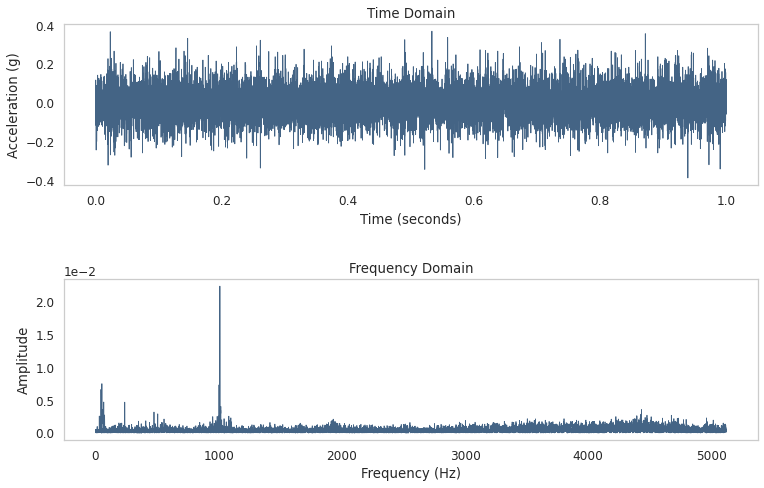

In [20]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch1', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

In their textbook, "Analysis of Time Series Structure: SSA and Related Techniques", Golyandina et al. discuss the process of applying singular value decomposition (SVD) to a time series. This method is called signular spectrum analysis (SSA).

SSA takes a time series and decomposes it into a "number of interpretable components such as a slowly varying trend, oscillatory components, and a 'structureless' noise." The interpretability of SSA makes it attractive for time series.

Here, we'll explore the SSA method in more detail by applying it to the time series of the bearing. You'll see how it is a powerful tool for analyzing machine signals.

The first step in SSA is to embed the time series into a series of lagged vectors. This embedding is called a "trajectory matrix."

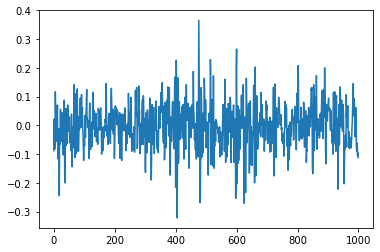

In [4]:
x = df["b1_ch1"].to_numpy(dtype="float64")[:1000] # convert to a numpy array
plt.plot(x)

In [5]:
N = len(x)  # number of sample points
L = 200 # window length, where 1 < L < N
K = N - L + 1 # number of lagged vectors
X = np.column_stack([x[i:i+L] for i in range(0,K)])
print("X.shape:", X.shape)

d = np.linalg.matrix_rank(X) # rank of X
print("Rank of X:", d)


U, S, VT = np.linalg.svd(X, full_matrices=False)

X_elem = np.array([S[i] * np.outer(U[:,i], VT[i,:]) for i in range(0,d)])


def trajectory_to_time_series(X_i):
    """Takes a trajectory matrix (also an elementary matrix), and with diagonal averaging,
    returns a time series."""

    # Mark Tolonen shows how to get all the diagnals from a matrix: https://stackoverflow.com/a/6313414 
    return np.array([X_i[::-1].diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


X.shape: (200, 801)
Rank of X: 200


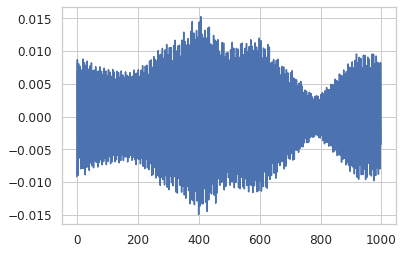

In [7]:

x_i = trajectory_to_time_series(X_elem[5])
plt.plot(x_i)


Use randomized SVD (code from https://youtu.be/vDSi271vUWk)

In [6]:
def r_svd(X, r, q=0, p=5):

    ny = X.shape[1]
    P = np.random.randn(ny, r+p)
    Z = X @ P
    for k in range (q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z, mode='reduced')

    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y, full_matrices=False)
    U = Q @ UY

    return U, S, VT

In [7]:
x = df["b1_ch1"].to_numpy(dtype="float64") # convert to a numpy array

N = len(x)  # number of sample points
L = 1000 # window length, where 1 < L < N
K = N - L + 1 # number of lagged vectors
X = np.column_stack([x[i:i+L] for i in range(0,K)])
print("X.shape:", X.shape)
# d = np.linalg.matrix_rank(X) # rank of X
# print("Rank of X:", d)

U, S, VT = r_svd(X, r=100, q=2, p=5)
print("S.shape:", S.shape)

X_elem = np.array([S[i] * np.outer(U[:,i], VT[i,:]) for i in range(0,U.shape[1])])

X.shape: (1000, 19481)
S.shape: (105,)


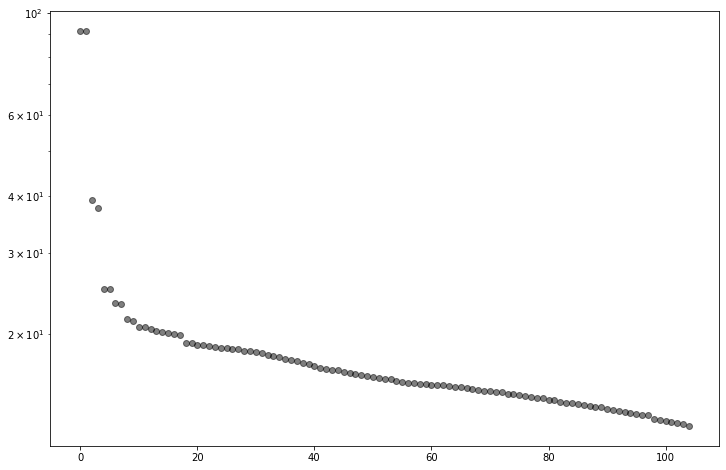

In [8]:
# plot singular values on a logy scale
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(S, marker="o", linestyle="None", color="black", alpha=0.5)
ax.set_yscale('log')

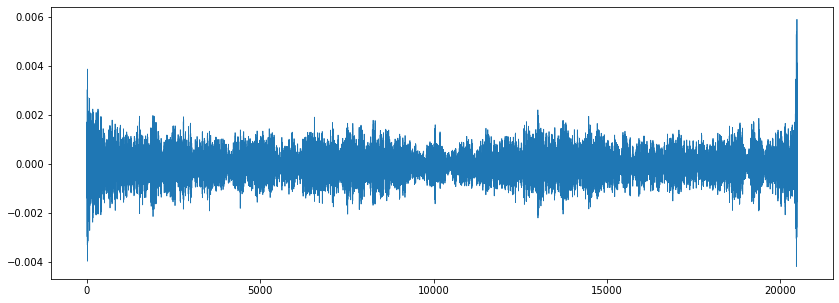

In [9]:
x_i = trajectory_to_time_series(X_elem[50])
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(x_i, linewidth=0.8,)


Use sklearn to calculate randomized svd

In [10]:
from sklearn.utils.extmath import randomized_svd

x = df["b1_ch1"].to_numpy(dtype="float64") # convert to a numpy array

N = len(x)  # number of sample points
L = 1000 # window length, where 1 < L < N
K = N - L + 1 # number of lagged vectors
X = np.column_stack([x[i:i+L] for i in range(0,K)])

U, S, VT = randomized_svd(X, n_components=100, n_oversamples=5, n_iter=2, random_state=42)

X_elem = np.array([S[i] * np.outer(U[:,i], VT[i,:]) for i in range(0, U.shape[1])])

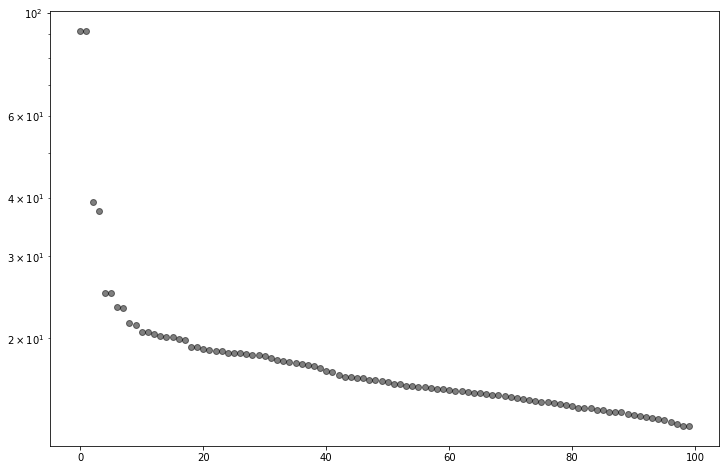

In [11]:
# plot singular values on a logy scale
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(S, marker="o", linestyle="None", color="black", alpha=0.5)
ax.set_yscale('log')

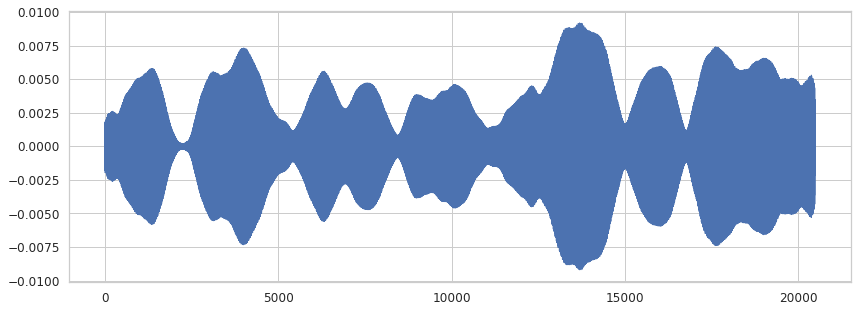

In [21]:
x_i = trajectory_to_time_series(X_elem[4])
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(x_i, linewidth=0.8,)

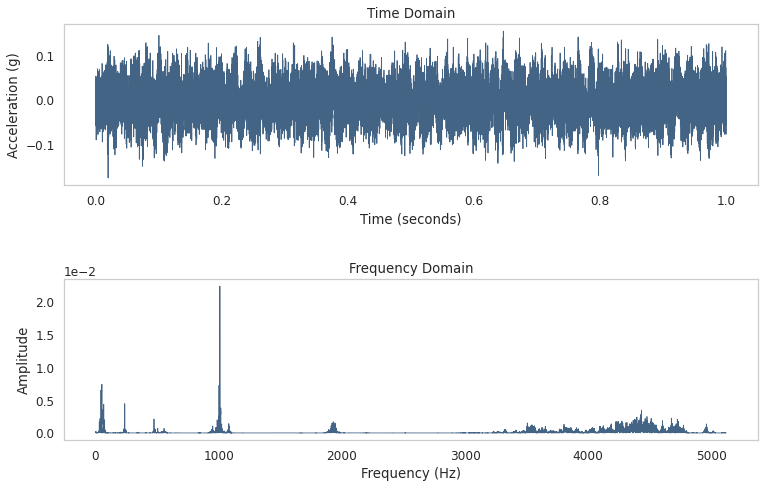

In [52]:
x_i = trajectory_to_time_series(X_elem[0:99].sum(axis=0))

# create fft
x, y, xf, yf = create_fft(x_i, y_name='b1_ch1', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

# Try on Toy Dataset

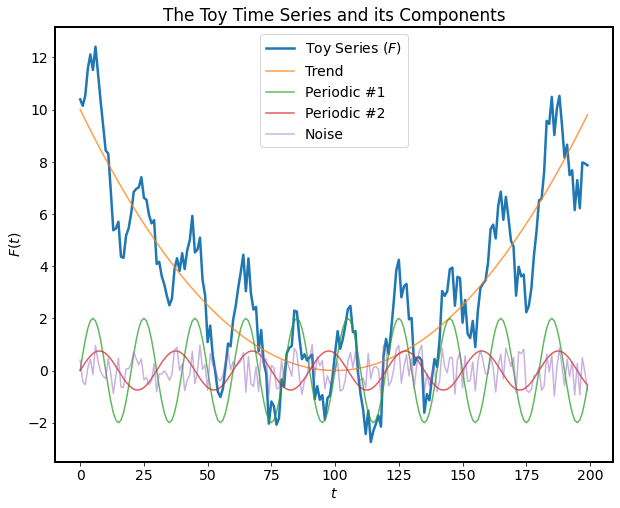

In [4]:
# try on toy dataset
from numpy import pi


# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");



In [5]:
len(F)

200

In [48]:
N = len(F)  # number of sample points
L = 70 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])

d = np.linalg.matrix_rank(X) # rank of X


U, S, VT = np.linalg.svd(X, full_matrices=False)
# V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array([S[i] * np.outer(U[:,i], VT[i,:]) for i in range(0,d)])
print(X_elem.shape)
X_elem[0]

(70, 70, 131)


array([[7.55537133, 7.41111552, 7.27476522, ..., 6.11186773, 6.1035773 ,
        6.13584833],
       [7.48082686, 7.33799435, 7.20298933, ..., 6.05156547, 6.04335684,
        6.07530947],
       [7.38963491, 7.24854353, 7.11518423, ..., 5.97779634, 5.96968777,
        6.0012509 ],
       ...,
       [5.96048121, 5.84667687, 5.73910924, ..., 4.8216919 , 4.81515153,
        4.84061035],
       [5.83856593, 5.72708934, 5.62172188, ..., 4.72306934, 4.71666275,
        4.74160084],
       [5.72481054, 5.6155059 , 5.51219136, ..., 4.63104767, 4.62476589,
        4.6492181 ]])

In [49]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])



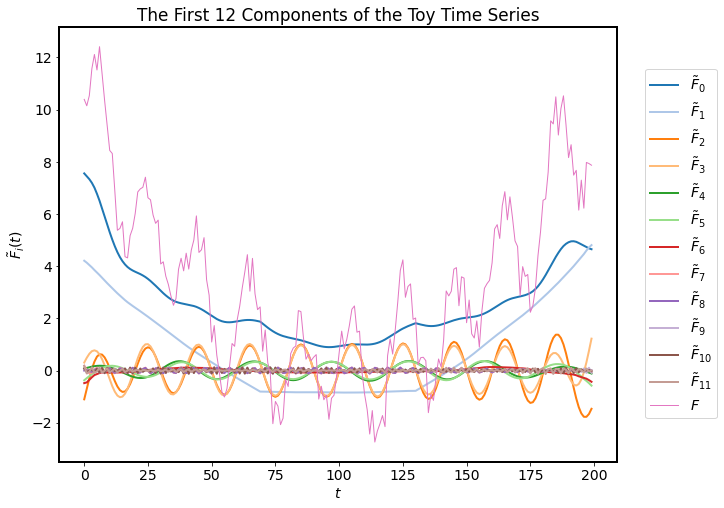

In [50]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));



In [37]:
X_approx = U[:,:1] @ S[0:1,:1] @ VT[:1,:]
print(X_approx.shape)

(70, 131)


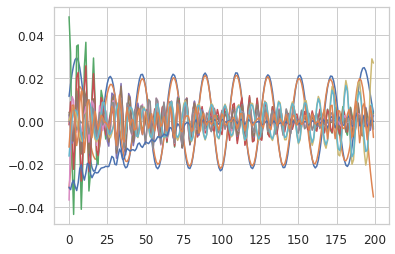

In [40]:
for r in range(12):
    X_approx = U[:,r:r+1] @ S[r:r+1,:r+1] @ VT[:r+1,:]
    plt.plot(X_to_TS(X_approx[::-1]))

# plt.plot(F)

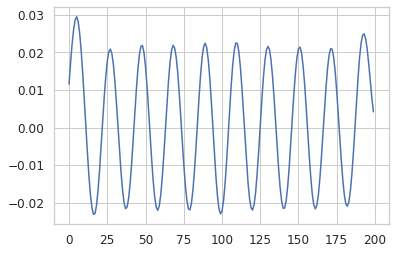

In [28]:
a = X_to_TS(X_approx)
plt.plot(a)